In [109]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [110]:
df = pd.read_excel('https://github.com/Zhanarik/magnum/blob/master/magnumdata.xlsx?raw=true')#loading data

In [112]:
data = df.copy()
data = data.drop(columns=['Month new'], axis=1)
# Depended variables that do not participate in analysis have been droped.Month new and Month columns are the same
data.head()

,Customer,Category,Brand,Demand Forecasting Group,Product Name,Product Code,Month,"Sales, CS"
0,OZON,DEODORANTS & FRAGRANCES,REXONA,Rex Aero Fem 150 ML,Rxn АП/АЭР ЖЕН Комфорт льна 150МЛ,441948A79E2070C01,2018-01-01,2.73
1,OZON,DEODORANTS & FRAGRANCES,REXONA,Rex Aero Fem 150 ML,Rxn АП/АЭР ЖЕН Комфорт льна 150МЛ,441948A79E2070C01,2018-02-01,8.19
2,OZON,DEODORANTS & FRAGRANCES,REXONA,Rex Aero Fem 150 ML,Rxn АП/АЭР ЖЕН Комфорт льна 150МЛ,441948A79E2070C01,2018-03-01,2.73
3,OZON,DEODORANTS & FRAGRANCES,REXONA,Rex Aero Fem 150 ML,Rxn АП/АЭР ЖЕН Комфорт льна 150МЛ,441948A79E2070C01,2018-04-01,5.46
4,OZON,DEODORANTS & FRAGRANCES,REXONA,Rex Aero Fem 150 ML,Rxn АП/АЭР ЖЕН Комфорт льна 150МЛ,441948A79E2070C01,2018-05-01,10.92


In [113]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [114]:
TRAIN_SPLIT = 26000 #train dataset would be 70% of the whole dataset

In [115]:
tf.random.set_seed(13)

In [116]:
uni_data = df['Sales, CS']
uni_data.index = df['Month']
uni_data.head()

Month
2018-01-01     2.73
2018-02-01     8.19
2018-03-01     2.73
2018-04-01     5.46
2018-05-01    10.92
Name: Sales, CS, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x145726b90>],
      dtype=object)

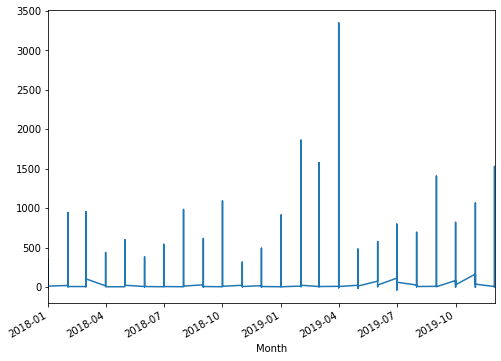

In [117]:
uni_data.plot(subplots=True)

In [118]:
uni_data = uni_data.values

In [119]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [120]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [121]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [122]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target sale to predict')
print (y_train_uni[0])

Single window of past history
[[-0.39248652]
 [-0.30991584]
 [-0.39248652]
 [-0.35120118]
 [-0.2686305 ]
 [-0.35120118]
 [-0.35120118]
 [-0.22734516]
 [-0.35120118]
 [-0.39248652]
 [-0.39248652]
 [-0.30991584]
 [-0.2686305 ]
 [-0.22734516]
 [-0.35120118]
 [-0.18605982]
 [-0.2686305 ]
 [-0.30991584]
 [-0.39248652]
 [-0.35120118]]

 Target sale to predict
-0.3099158380433544


In [123]:
def create_time_steps(length):
  return list(range(-length, 0))

In [124]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

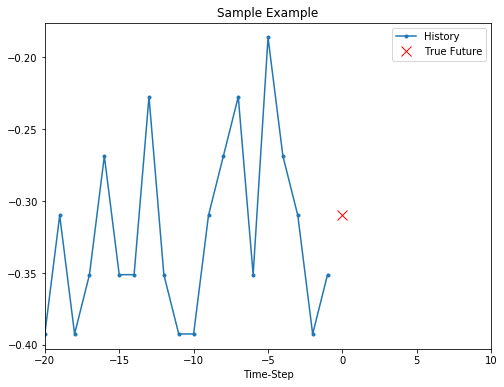

In [125]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [126]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

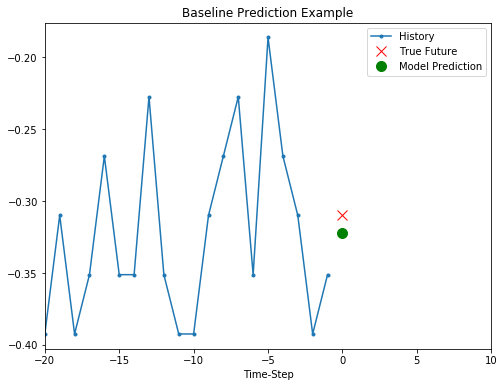

In [127]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [128]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [129]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [130]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [131]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.3322 - val_loss: 0.2366
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3212 - val_loss: 0.2323
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3193 - val_loss: 0.2280
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3152 - val_loss: 0.2240
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3141 - val_loss: 0.2248
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3126 - val_loss: 0.2227
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3143 - val_loss: 0.2211
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3125 - val_loss: 0.2208
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3075 - val_loss: 0.2192
Epoch 10/10
200/200 [==============================] - 1

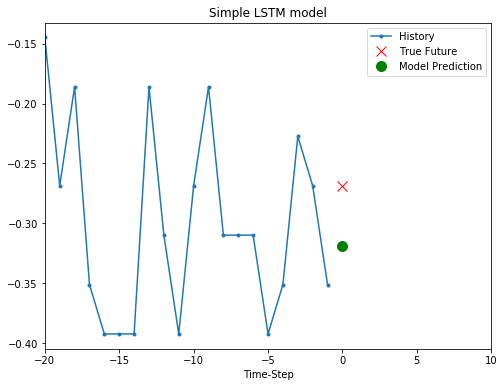

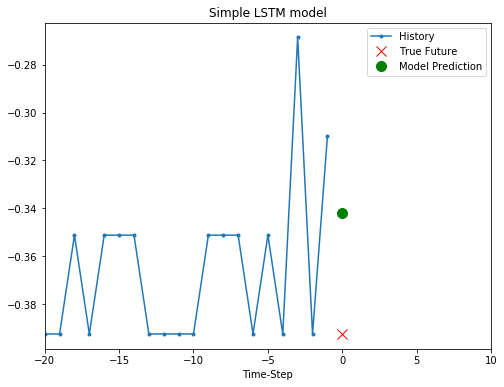

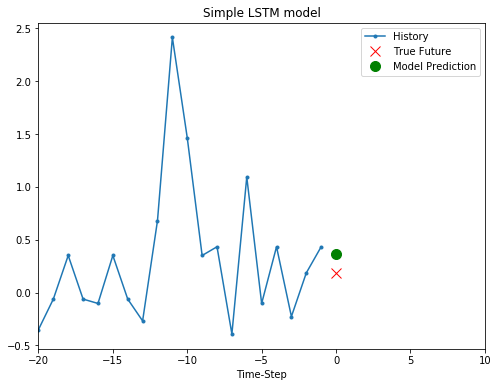

In [132]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [133]:
df.groupby(['Brand']).mean()

,"Sales, CS"
Brand,
100 BEAUTY RECIPES,9.165023
32 BIONORMA,6.390682
AHC,6.006000
AXE,23.877164
BALTIMOR,8.588369
BESEDA,14.512105
BLACK PEARL,19.159384
BROOKE BOND,7.659167
CALVE,7.748252


In [134]:
df.groupby(['Customer']).mean()

,"Sales, CS"
Customer,
OZON,33.135502
UTKONOS,23.645621
WILDBERRIES,69.925227
YANDEX,9.650409


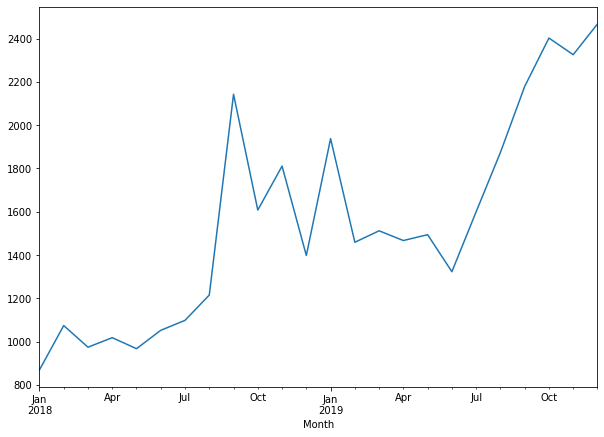

In [135]:
fig, ax = plt.subplots(figsize=(10,7))
data.groupby(['Month']).count()['Sales, CS'].plot(ax=ax)

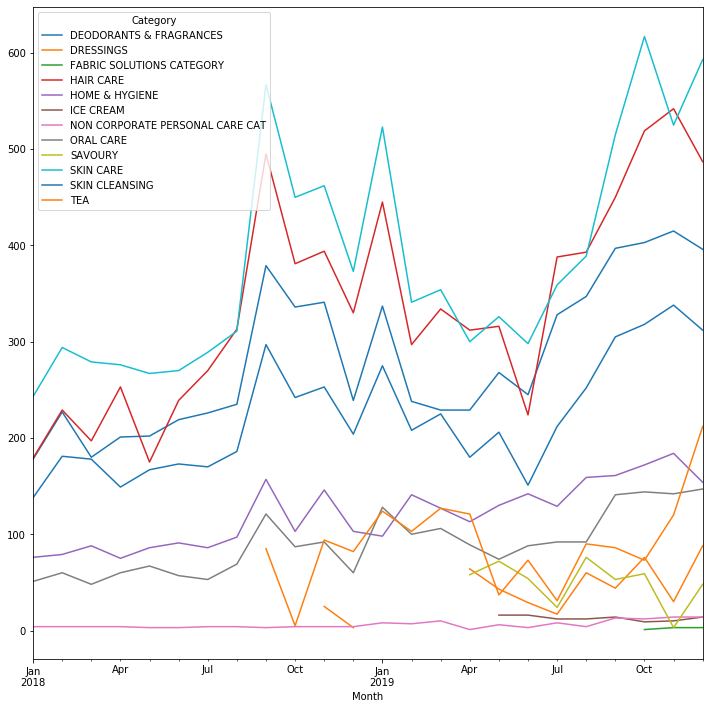

In [136]:
fig, ax = plt.subplots(figsize=(12,12))
data.groupby(['Month','Category']).count()['Sales, CS'].unstack().plot(ax=ax)

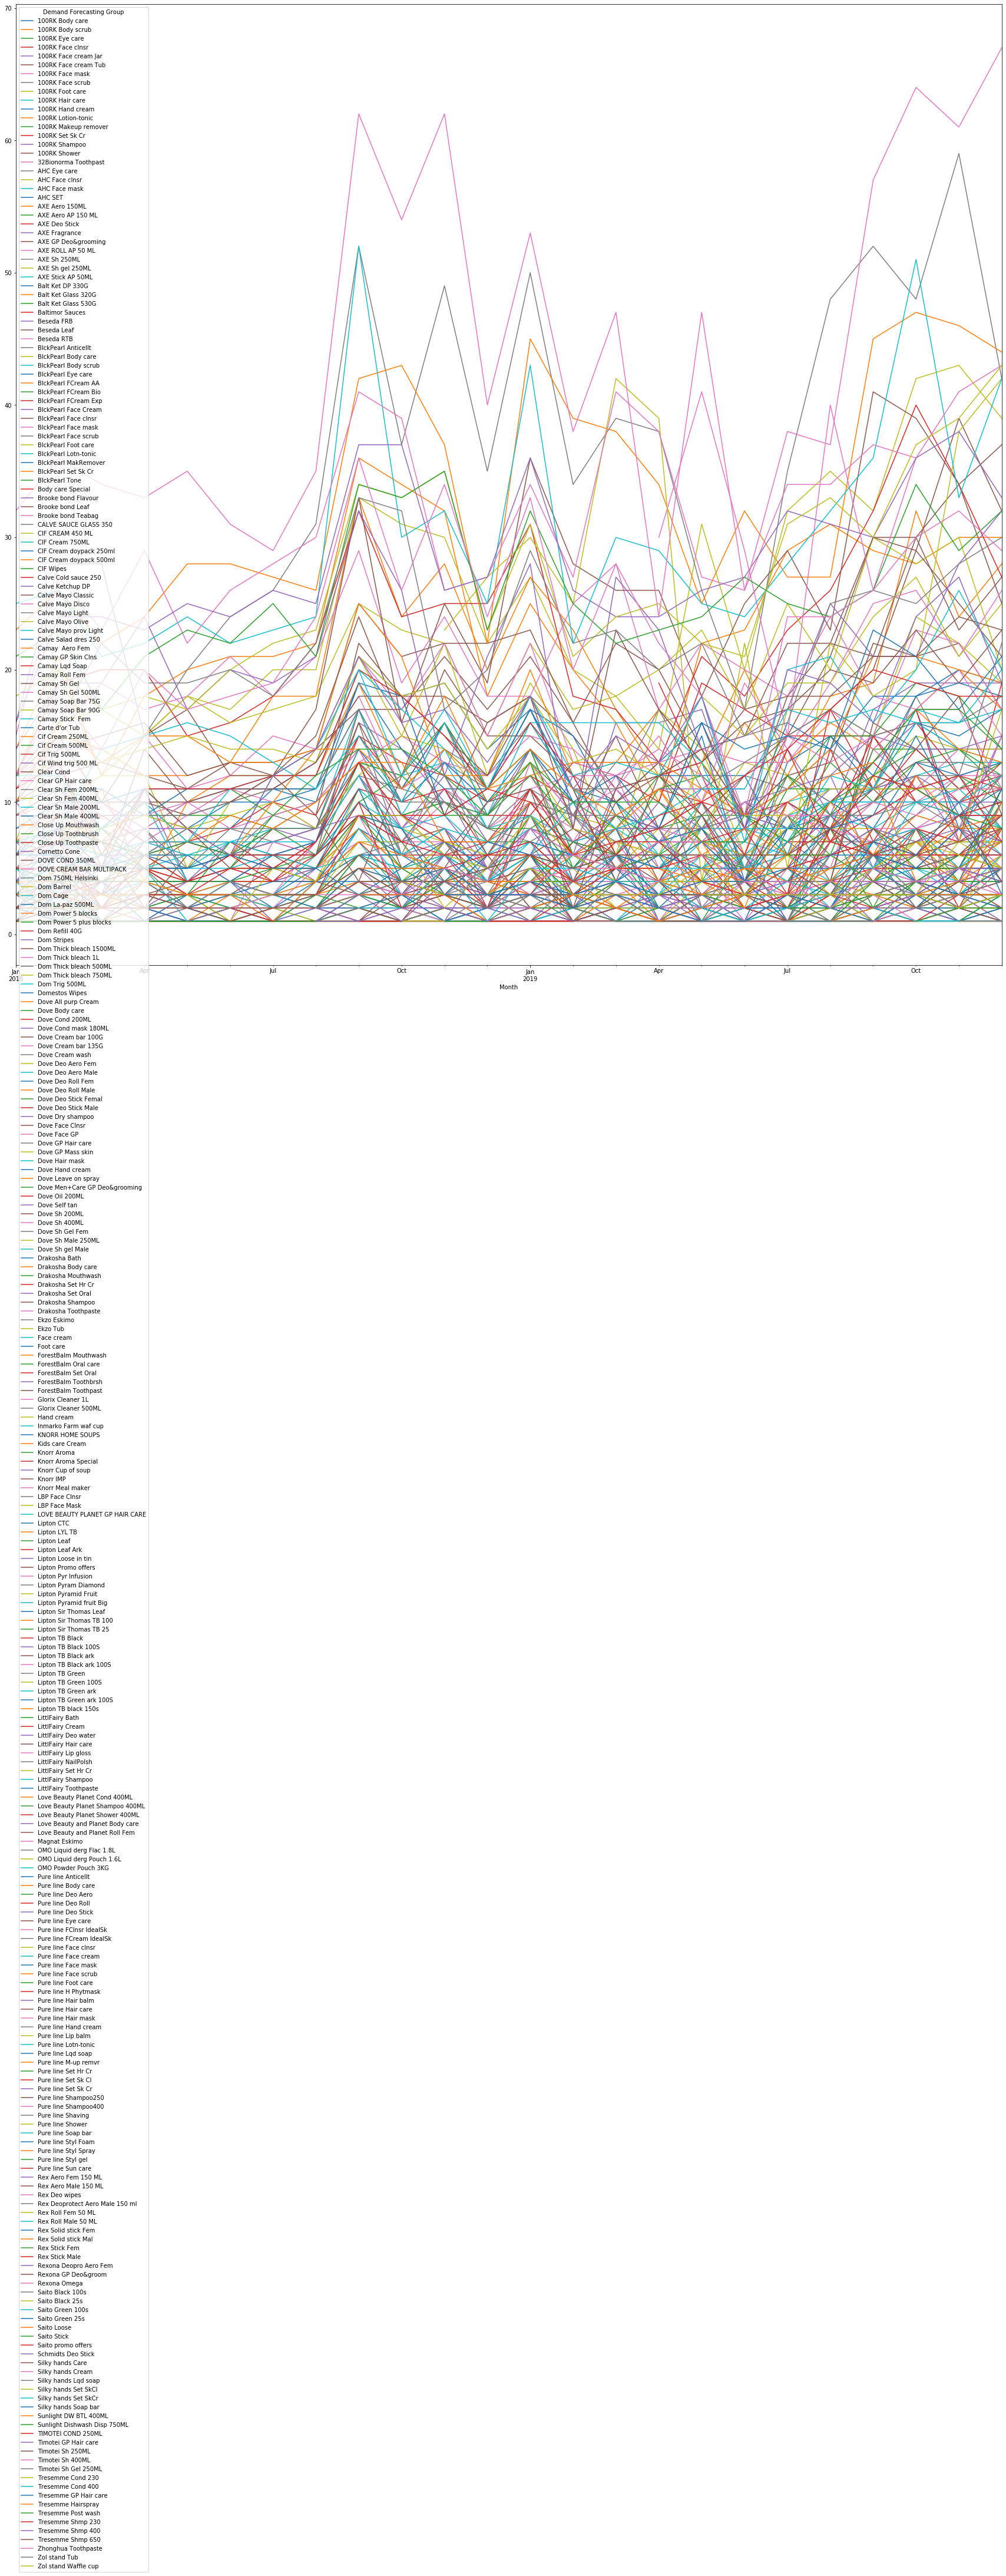

In [137]:
fig, ax = plt.subplots(figsize=(30,30))
data.groupby(['Month','Demand Forecasting Group']).count()['Sales, CS'].unstack().plot(ax=ax)